# Task 5 *Traffic sign classification/Recognition system* 
(Level - Intermediate)


## A task

* Train a multiclass classifier of road signs from the image on the dataset of German road signs ["German Traffic Sign Recognition Benchmark" (GTSRB)] (http://benchmark.ini.rub.de/?section=gtsrb);
* Evaluate the accuracy and speed of the classifier on a test sample on the CPU. 


As part of solving the problem, an analysis of scientific articles in the field of road sign recognition by images was carried out. The analysis itself will not be presented in this work.

Based on the analysis results, the neural network model proposed in this article was chosen for implementation - [MicronNet: A Highly Compact Deep Convolutional Neural Network Architecture for Real-time Embedded Traffic Sign Classification] (https://arxiv.org/pdf/1804.00497v3.pdf ). It was chosen by me because of the impressive ratio of classification accuracy to the size of the model itself.

## Solution plan:

0. [Installing required packages](# step0);
1. [Downloading data](# step1);
2. [EDA by data](# step2);
3. [Data preprocessing before the stage of model training](# step3);
4. [Train the model](# step4);
5. [Quality assessment on a test sample](# step5);

## Build

#### Required imports 

In [ ]:
import glob
import os
import random as rn
from collections import Counter

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras
import tensorflow.keras.backend as K
import tensorflow.keras.layers as kl
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import Sequence


<a id='step1'></a>

## 1. Downloading Data

First Make a FIle named data for having all image files

In [ ]:

!mkdir data

!curl --url https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip -o data/GTSRB_Final_Training_Images.zip
!curl --url https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip -o data/GTSRB_Final_Test_Images.zip
!curl --url https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_GT.zip -o data/GTSRB_Final_Test_GT.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  263M  100  263M    0     0  70.4M      0  0:00:03  0:00:03 --:--:-- 70.4M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 84.8M  100 84.8M    0     0  59.2M      0  0:00:01  0:00:01 --:--:-- 59.2M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 99620  100 99620    0     0   308k      0 --:--:-- --:--:-- --:--:--  307k


In [ ]:
!ls data

GTSRB_Final_Test_GT.zip      GTSRB_Final_Training_Images.zip
GTSRB_Final_Test_Images.zip


In [ ]:
!unzip data/GTSRB_Final_Training_Images.zip -d data/ > /dev/null 2>&1
!unzip data/GTSRB_Final_Test_Images.zip -d data/ > /dev/null 2>&1
!unzip data/GTSRB_Final_Test_GT.zip -d data/

Archive:  data/GTSRB_Final_Test_GT.zip
  inflating: data/GT-final_test.csv  


#### Download files with all the Sign Names 

In [ ]:
!wget https://raw.githubusercontent.com/m9taa/keras-micronnet/master/sign_names.txt

--2021-06-17 14:21:27--  https://raw.githubusercontent.com/m9taa/keras-micronnet/master/sign_names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 858 [text/plain]
Saving to: ‘sign_names.txt’

sign_names.txt      100%[===================>]     858  --.-KB/s    in 0s      

2021-06-17 14:21:28 (39.3 MB/s) - ‘sign_names.txt’ saved [858/858]



In [ ]:
%ls

data/  sample_data/  sign_names.txt


<a id='step2'></a>

## 2. EDA by Data

Consider the volumes of available samples

In [ ]:
print('The number of classes in the dataset: {}'.format(len(glob.glob('data/GTSRB/Final_Training/Images/*'))))
print('Number of examples for training: {}'.format(len(glob.glob('data/GTSRB/Final_Training/Images/*/*.ppm'))))
print('The number of examples in the test sample: {}'.format(len(glob.glob('data/GTSRB/Final_Test/Images/*.ppm'))))

The number of classes in the dataset: 43
Number of examples for training: 39209
The number of examples in the test sample: 12630


Let's look at the images

In [ ]:
def get_sign_names_mapping(filepath):
    idx2sign_name = {}
    with open(filepath, 'r') as f:
        for idx, sign_name in enumerate(f):
            idx2sign_name[idx] =  sign_name.strip()
    return idx2sign_name

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  if __name__ == '__main__':


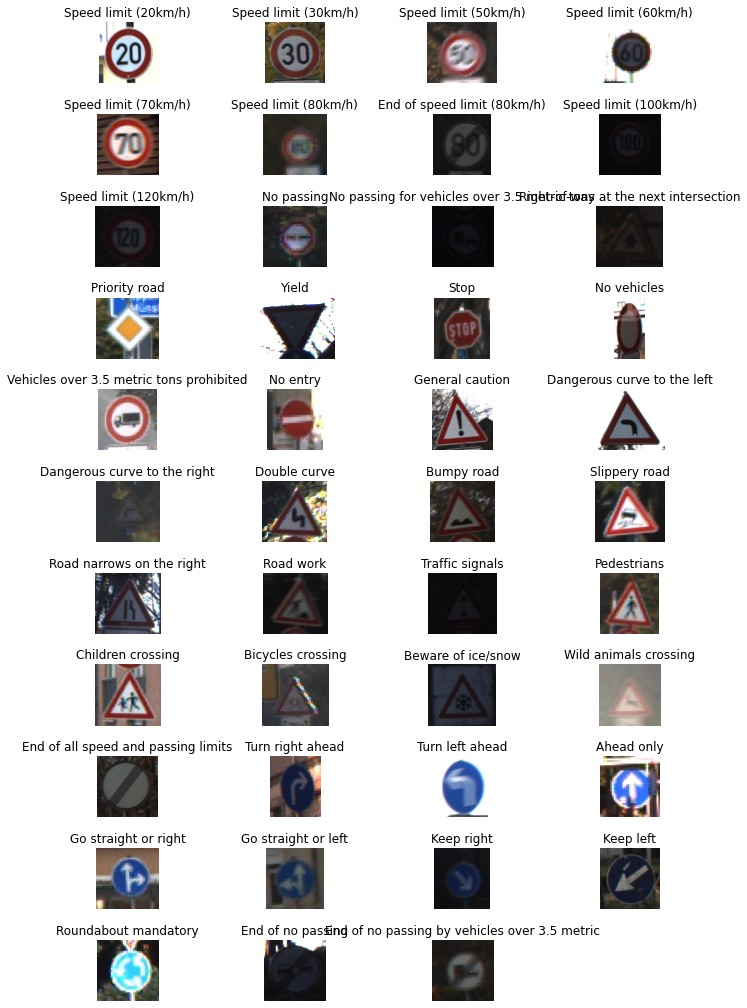

In [ ]:
TRAIN_IMAGES_DIR = 'data/GTSRB/Final_Training/Images'
NUM_CLASSES = 43

n_rows, n_cols = 11, 4

idx2sign_name = get_sign_names_mapping(filepath='sign_names.txt')

fig, axs = plt.subplots(n_rows, n_cols, figsize=(12,18), constrained_layout=True)
fig.subplots_adjust(hspace=0.5, wspace=0.0)

for idx, class_path in enumerate(sorted(glob.glob(TRAIN_IMAGES_DIR + '/*'))):
    img_path = np.random.choice(glob.glob(class_path + '/*.ppm'))
    raw_img = cv2.imread(img_path)
#     rgb_img = cv2.cvtColor(hsv_img, cv2.COLOR_HSV2RGB)
    rgb_img = cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB)
    axs[idx // n_cols, idx % n_cols].set_title(idx2sign_name[idx])
    axs[idx // n_cols, idx % n_cols].grid(False)
    axs[idx // n_cols, idx % n_cols].axis('off')
    axs[idx // n_cols, idx % n_cols].imshow(rgb_img)
axs[NUM_CLASSES // n_cols, NUM_CLASSES % n_cols].grid(False)
axs[NUM_CLASSES // n_cols, NUM_CLASSES % n_cols].axis('off')
plt.show()

The images show a strong difference in brightness between classes, and you can also see that the images have different aspect ratios - an example of Children crossing and Bicycles crossing.

In addition to rgb images, the dataset contains tabular data describing the following parameters of each image:

* Image file name - Filename;
* Width and height of the image in pixels - Width and Height, respectively;
* Coordinates of the upper left and lower right points of the rectangle framing the sign - (Roi.X1, Roi.Y1), (Roi.X2, Roi.Y2);
* An indication of the class to which the sign belongs - ClassId

For convenience, let's combine all tables into one DataFrame 

In [ ]:
annotation_paths = sorted(glob.glob('data/GTSRB/Final_Training/*/*/*csv'))

annotation_df = pd.concat([pd.read_csv(path, sep=';') for path in annotation_paths], ignore_index=True)
annotation_df.head()

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId
0,00000_00000.ppm,29,30,5,6,24,25,0
1,00000_00001.ppm,30,30,5,5,25,25,0
2,00000_00002.ppm,30,30,5,5,25,25,0
3,00000_00003.ppm,31,31,5,5,26,26,0
4,00000_00004.ppm,30,32,5,6,25,26,0


Let's define for each file the corresponding (physical) sign

In [ ]:
annotation_df['unique_sign'] = annotation_df['ClassId'].astype(str).str.zfill(5) + "/" + annotation_df['Filename'].str.split('_', expand=True)[0]
annotation_df.head()

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,unique_sign
0,00000_00000.ppm,29,30,5,6,24,25,0,00000/00000
1,00000_00001.ppm,30,30,5,5,25,25,0,00000/00000
2,00000_00002.ppm,30,30,5,5,25,25,0,00000/00000
3,00000_00003.ppm,31,31,5,5,26,26,0,00000/00000
4,00000_00004.ppm,30,32,5,6,25,26,0,00000/00000


In [ ]:
annotation_df['unique_sign'].value_counts()

00018/00038    30
00019/00006    30
00014/00003    30
00025/00035    30
00033/00006    30
               ..
00002/00042    30
00002/00006    30
00010/00026    30
00025/00048    30
00033/00019    29
Name: unique_sign, Length: 1307, dtype: int64

In [ ]:
len(annotation_df['unique_sign'].unique())

1307

In total, there are 1307 unique characters in the training set, 30 images for each character (except for one - 29 images with such a character).

Let us consider whether the brightness of the images changes in the section of one class. 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  if __name__ == '__main__':


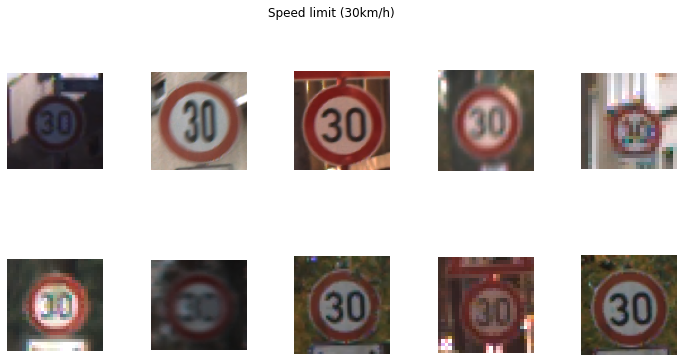

In [ ]:
sign_class_number = 1

n_rows, n_cols = 2, 5

sign_samples = annotation_df.query('ClassId == @sign_class_number') # pd.Dataframe
sign_samples = sign_samples['unique_sign'].sample(n=n_rows*n_cols, random_state=42) # pd.Series

fig, axs = plt.subplots(n_rows, n_cols, figsize=(12,6), constrained_layout=True)
fig.subplots_adjust(hspace=0.3, wspace=0.5)
fig.suptitle(idx2sign_name[sign_class_number])

for idx, sign in enumerate(sign_samples.values):
    filename = np.random.choice(annotation_df.query('unique_sign == @sign')['Filename'].values, size=1)[0]
    img_path = os.path.join(TRAIN_IMAGES_DIR, '{0:0>5}'.format(sign_class_number), filename) #train_images_dir
    raw_img = cv2.imread(img_path)
    rgb_img = cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB)
    axs[idx // n_cols, idx % n_cols].grid(False)
    axs[idx // n_cols, idx % n_cols].axis('off')
    axs[idx // n_cols, idx % n_cols].imshow(rgb_img)
plt.show()

Let's look at the distribution of classes in the training set 

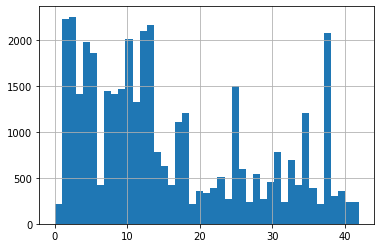

In [ ]:
annotation_df['ClassId'].hist(bins=NUM_CLASSES)

### Outcome:
* The images in the sample show strong changes in brightness, which means that during the preprocessing stage of the images it is worth including the equalization of the image histogram.
* Variety of aspect ratios of images, pushes to the next approach - it is worth cutting out images of a road sign along its framing rectangle, and then resizing the image to a square one, for example 48 * 48.
* Classes are not balanced - it is worth introducing class weight to achieve a balance during training, and it is also worth expanding the sample with augmentations; 

<a id='step3'></a>

## 3. Data preprocessing before the stage of model training

Let's write a number of helper functions for image preprocessing. To train the model, we will prepare a datagenerator that will perform the following sequence of actions for each image:

* Load the image into memory along the given path to it;
* Image preprocessing
 * Equalize image brightness using histogram equalization;
 * Cut the image of the sign from the original image using known coordinates;
 * Resize images to pre-selected;
* Augment the image.

Let's prepare a dataframe for convenient extraction of information about a specific image.

### Data generator

In [ ]:
train_df = annotation_df.set_index(['ClassId','Filename'])
train_df.loc[0].loc['00000_00000.ppm']

Width                   29
Height                  30
Roi.X1                   5
Roi.Y1                   6
Roi.X2                  24
Roi.Y2                  25
unique_sign    00000/00000
Name: 00000_00000.ppm, dtype: object

In [ ]:
def get_img_class(img_path):
    return int(img_path.split('/')[-2])
    
get_img_class(os.path.join(TRAIN_IMAGES_DIR, '00011/00000_00000.ppm'))

11

Retrieving the coordinates of the points of the bounding rectangle from the given file path

In [ ]:
def get_sign_coords(img_path, is_train=True):
    im_name = img_path.split('/')[-1]
    
    if is_train:
        pic_class = get_img_class(img_path)
        df_row = train_df.loc[pic_class].loc[im_name]
    else:
        df_row = test_df.loc[im_name]
    
    x1, y1, x2, y2 = df_row['Roi.X1'], df_row['Roi.Y1'], df_row['Roi.X2'], df_row['Roi.Y2']
    return (x1, y1, x2, y2)
    
get_sign_coords(os.path.join(TRAIN_IMAGES_DIR, '00011/00000_00000.ppm'))

(5, 6, 22, 21)

Image augmentation

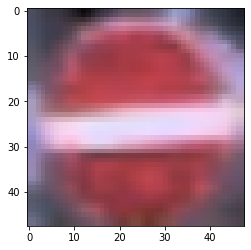

In [ ]:
def preprocess_img(img_path):
    bgr_img = cv2.imread(img_path)
    
    hsv_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2HSV)
    hsv_img[...,2] = cv2.equalizeHist(hsv_img[...,2])
    
    rgb_img = cv2.cvtColor(hsv_img, cv2.COLOR_HSV2RGB)
    return rgb_img

def crop_n_resize_img(img, pt1, pt2, dsize):
    (x1, y1), (x2, y2) = pt1, pt2
    cropped_img = img[y1:y2, x1:x2]
    resized_img = cv2.resize(cropped_img, (dsize,dsize))
    return resized_img
    

img_path = os.path.join(TRAIN_IMAGES_DIR, '00017/00000_00015.ppm')
x1, y1, x2, y2 = get_sign_coords(img_path)

processed_img = preprocess_img(img_path)
resized_img = crop_n_resize_img(processed_img, (x1,y1), (x2,y2), dsize=48)

plt.imshow(resized_img)
plt.show()

Let's write a datagenerator class that works with paths to source images.

In [ ]:
class DataGenerator(Sequence):

    def __init__(self, path_list, labels, n_classes, batch_size, img_size,
                 n_channels, shuffle=True, use_augs=False, is_train=True):
        self.img_size = img_size
        self.batch_size = batch_size
        self.labels = labels
        self.path_list = path_list
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.use_augs = use_augs
        self.is_train = is_train
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.path_list) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X, y = self.__data_generation(indexes)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.path_list))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, indexes):
        X = np.empty((self.batch_size, self.img_size, self.img_size, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        for i, idx in enumerate(indexes):
            img_path = self.path_list[idx]
            processed_img = preprocess_img(img_path)
            x1, y1, x2, y2 = get_sign_coords(img_path, is_train=self.is_train)
            resized_img = crop_n_resize_img(processed_img, (x1,y1), (x2,y2), dsize=self.img_size)
            
            X[i] = resized_img / 255
            y[i] = self.labels[idx]

        return X, tensorflow.keras.utils.to_categorical(y, num_classes=self.n_classes)

### Train dev split

Let's make a stratified division of the training sample into the following two:

* Subsampling for training the model;
* Subsampling for the selection of hyperparameters and quality assessment in the learning process.

The partitioning will be performed by unique characters from the sample, this is done to avoid mixing images of the same character into both subsamples.

The division is made in the ratio: "Training" 75% - "Quality rating" 25%. 

In [ ]:
sign_list = annotation_df['unique_sign'].unique()
labels = [get_img_class(sign_name) for sign_name in sign_list]

train_signs, dev_signs = train_test_split(sign_list, train_size=0.75, 
                                          stratify=labels, random_state=123)

train_paths = []
for sign_name in train_signs:
    train_paths.extend(glob.glob(os.path.join(TRAIN_IMAGES_DIR, sign_name + '*.ppm')))
    
dev_paths = []
for sign_name in dev_signs:
    dev_paths.extend(glob.glob(os.path.join(TRAIN_IMAGES_DIR, sign_name + '*.ppm')))

train_labels = [get_img_class(sign_name) for sign_name in train_paths]
dev_labels = [get_img_class(sign_name) for sign_name in dev_paths]
len(train_labels), len(dev_labels), len(train_paths), len(dev_paths)

(29399, 9810, 29399, 9810)

We also introduce weights class_weight for balancing classes during training.

In [ ]:
def create_class_weight(labels_dict, mu=0.15):
    total = np.sum(list(labels_dict.values()))
    keys = labels_dict.keys()
    class_weight = dict()

    for key in keys:
        score = np.log(mu*total/float(labels_dict[key]))
        class_weight[key] = score if score > 1.0 else 1.0

    return class_weight


labels_dict = Counter(labels)

class_weight = create_class_weight(labels_dict)

<a id='step4'></a>

## 4. Model training

This section reproduces the process of training the model as described in the article:

* Approach to optimize the loss function - SGD (learning rate = 0.007) with Momentum (momentum value = 0.9);
* Exponential decrease in the learning rate by a factor of 0.9996 every 2 learning epochs;
* L2 regularization on convolutional filters and matrices of fully connected layers with a regularization factor of 0.00001.

The architecture of the model is described below. 

In [ ]:
IMG_SIZE = 48
l2_reg_rate = 1e-5
eps = 1e-6

def get_micronet():
    input_ = kl.Input(shape=(IMG_SIZE,IMG_SIZE,3), name='data')
    # 1-part
    x = kl.Conv2D(filters=1, kernel_size=(1,1), padding='same', kernel_regularizer=l2(l2_reg_rate))(input_)
    x = kl.BatchNormalization(epsilon=eps)(x)
    x = kl.ReLU()(x)
    # 2-part
    x = kl.Conv2D(filters=29, kernel_size=(5,5), kernel_regularizer=l2(l2_reg_rate))(x)
    x = kl.BatchNormalization(epsilon=eps)(x)
    x = kl.ReLU()(x)
    x = kl.MaxPooling2D(pool_size=3, strides=2)(x)
    # 3-part
    x = kl.Conv2D(filters=59, kernel_size=(3,3), padding='same', kernel_regularizer=l2(l2_reg_rate))(x)
    x = kl.BatchNormalization(epsilon=eps)(x)
    x = kl.ReLU()(x)
    x = kl.MaxPooling2D(pool_size=3, strides=2)(x)
    # 4-part
    x = kl.Conv2D(filters=74, kernel_size=(3,3), padding='same', kernel_regularizer=l2(l2_reg_rate))(x)
    x = kl.BatchNormalization(epsilon=eps)(x)
    x = kl.ReLU()(x)
    x = kl.MaxPooling2D(pool_size=3, strides=2)(x)
    # 5-part
    x = kl.Flatten()(x)
    x = kl.Dense(300, kernel_regularizer=l2(l2_reg_rate))(x)
    x = kl.BatchNormalization(epsilon=eps)(x)
    x = kl.ReLU()(x)
    x = kl.Dense(300)(x)
    x = kl.ReLU()(x)
    x = kl.Dense(NUM_CLASSES)(x)
    x = kl.Softmax()(x)
    return Model(inputs=input_, outputs=x)


In [ ]:
BATCH_SIZE = 50

train_generator = DataGenerator(
    path_list=train_paths,
    labels=train_labels,
    n_classes=NUM_CLASSES,
    batch_size=BATCH_SIZE,
    img_size=IMG_SIZE,
    n_channels=3,
    shuffle=True,
    use_augs=True,
)

dev_generator = DataGenerator(
    path_list=dev_paths,
    labels=dev_labels,
    n_classes=NUM_CLASSES,
    batch_size=BATCH_SIZE,
    img_size=IMG_SIZE,
    n_channels=3,
    shuffle=True,
    use_augs=False,
)

In [ ]:
def create_lr_decay(decay_step_size, lr_decay_rate):
    def lr_decay(epoch, lr):
        if epoch % decay_step_size == 0:
            lr = lr * lr_decay_rate
        return lr
    return lr_decay

lr = 0.0007
lr_decay = create_lr_decay(decay_step_size=2, lr_decay_rate=0.9996)

In [ ]:
weights_path = 'weights'
if not os.path.exists(weights_path):
    os.makedirs(weights_path)

model_name = '2019-08-07-micronnet-model'

monitor = 'val_categorical_accuracy'
model_path = os.path.join(weights_path, model_name + '-epoch-{epoch:02d}-val_cat_acc-{val_categorical_accuracy:.3f}.hdf5')

model_checkpoint = ModelCheckpoint(model_path, monitor=monitor, save_best_only=True, verbose=1)
lr_sched = LearningRateScheduler(lr_decay)

callbacks = [
    model_checkpoint,
    lr_sched,
]

In [ ]:
K.clear_session()

model = get_micronet()

opt = tensorflow.keras.optimizers.SGD(
    learning_rate=lr,
    momentum=0.9,
    nesterov=True,
)

model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

In [ ]:
model.fit_generator(
    generator=train_generator,
    epochs=100,
    validation_data=dev_generator,
    class_weight=class_weight,
)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
587/587 [==============================] - 83s 90ms/step - loss: 3.1091 - categorical_accuracy: 0.5342 - val_loss: 1.2202 - val_categorical_accuracy: 0.6842
Epoch 2/100
587/587 [==============================] - 52s 89ms/step - loss: 0.8686 - categorical_accuracy: 0.8910 - val_loss: 0.3612 - val_categorical_accuracy: 0.9194
Epoch 3/100
587/587 [==============================] - 52s 88ms/step - loss: 0.2671 - categorical_accuracy: 0.9704 - val_loss: 0.2233 - val_categorical_accuracy: 0.9488
Epoch 4/100
587/587 [==============================] - 53s 89ms/step - loss: 0.1463 - categorical_accuracy: 0.9855 - val_loss: 0.1695 - val_categorical_accuracy: 0.9604
Epoch 5/100
587/587 [==============================] - 53s 90ms/step - loss: 0.0977 - categorical_accuracy: 0.9910 - val_loss: 0.1365 - val_categorical_accuracy: 0.9667
Epoch 6/100
587/587 [==============================] - 53s 90ms/step - loss: 0.0710 - categorical_accuracy: 0.9939 - val_loss: 0.1254 - val_categorical_acc

<a id='step5'></a>
## 5. Quality assessment on a test sample

Let's prepare a test sample for quality assessment.

In [ ]:
TEST_IMAGES_DIR = 'data/GTSRB/Final_Test/Images'

test_df = pd.read_csv('data/GT-final_test.csv', sep=';')
test_df.head()

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId
0,00000.ppm,53,54,6,5,48,49,16
1,00001.ppm,42,45,5,5,36,40,1
2,00002.ppm,48,52,6,6,43,47,38
3,00003.ppm,27,29,5,5,22,24,33
4,00004.ppm,60,57,5,5,55,52,11


In [ ]:
test_paths = TEST_IMAGES_DIR + os.sep + test_df['Filename']
test_labels = test_df['ClassId']

(test_paths[2], test_labels[2]), (test_paths[4], test_labels[4]),

(('data/GTSRB/Final_Test/Images/00002.ppm', 38),
 ('data/GTSRB/Final_Test/Images/00004.ppm', 11))

In [ ]:
test_df = test_df.set_index('Filename')

In [ ]:
BATCH_SIZE = 50
IMG_SIZE = 48

test_generator = DataGenerator(
    path_list=test_paths,
    labels=test_labels,
    n_classes=NUM_CLASSES,
    batch_size=BATCH_SIZE,
    img_size=IMG_SIZE,
    n_channels=3,
    shuffle=False,
    use_augs=False,
    is_train=False
)

Measurement of the quality of the classifier

In [ ]:
test_loss, test_cat_acc = model.evaluate_generator(test_generator)
print('Accuracy of the classifier on the test sample: {:.4%}'.format(test_cat_acc))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Accuracy of the classifier on the test sample: 97.1984%


Visualizing the error matrix

In [ ]:
# def plot_confusion_matrix(y_true, y_pred, classes,
#                           normalize=False,
#                           title=None,
#                           cmap=plt.cm.Blues):

#     if not title:
#         if normalize:
#             title = 'Normalized confusion matrix'
#         else:
#             title = 'Confusion matrix, without normalization'

#     cm = confusion_matrix(y_true, y_pred)
#     if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     fig, ax = plt.subplots(figsize=(15,15))
#     im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
#     ax.figure.colorbar(im, ax=ax)
#     ax.set(xticks=np.arange(cm.shape[1]),
#            yticks=np.arange(cm.shape[0]),
#            xticklabels=classes, yticklabels=classes,
#            title=title,
#            ylabel='True label',
#            xlabel='Predicted label')
#     plt.setp(ax.get_xticklabels(), rotation=0, ha="right",
#              rotation_mode="anchor")

#     thresh = cm.max() / 2.
#     for i in range(cm.shape[0]):
#         for j in range(cm.shape[1]):
#             value = cm[i, j]
#             if value == 0 or value == 1:
#                 value = int(value)
#             ax.text(j, i, round(value, 2),
#                     ha="center", va="center",
#                     color="white" if cm[i, j] > thresh else "black")
#     fig.tight_layout()
#     return ax


# np.set_printoptions(precision=2)

# class_names=range(43)
# plot_confusion_matrix(test_labels, pred_labels, classes=class_names, normalize=True,
#                       title='Normalized confusion matrix')

# plt.show()